# Sensibilidade do preço:

Pretendo analisar o efeito do preço na demanda de cada produto.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_excel("../data/online_retail_cleaned.xlsx")
df.head()

,invoice_no,stock_code_cleaned,description_cleaned,quantity_cleaned,invoice_date,unit_price_cleaned,customer_id,country_cleaned
0,536620,21058,party invites woodland,12,2010-12-02 10:27:00,0.85,14135,united kingdom
1,536620,21060,party invites balloon girl,12,2010-12-02 10:27:00,0.85,14135,united kingdom
2,536620,21061,party invites football,12,2010-12-02 10:27:00,0.85,14135,united kingdom
3,536620,21062,party invites spaceman,12,2010-12-02 10:27:00,0.85,14135,united kingdom
4,536620,21719,lovely bonbon sticker sheet,12,2010-12-02 10:27:00,0.85,14135,united kingdom


# Criando Receita:

definimos receita como:

$Receita = Quantidade \times Preço$

In [6]:
df["revenue"] = df["unit_price_cleaned"] * df["quantity_cleaned"]

df[['description_cleaned', 'unit_price_cleaned', 'quantity_cleaned', 'revenue']].head()

,description_cleaned,unit_price_cleaned,quantity_cleaned,revenue
0,party invites woodland,0.85,12,10.2
1,party invites balloon girl,0.85,12,10.2
2,party invites football,0.85,12,10.2
3,party invites spaceman,0.85,12,10.2
4,lovely bonbon sticker sheet,0.85,12,10.2


# Agrupando por produto (stock_code):

Criando um novo dataframe (product_df) contendo o preço médio, a quantidade vendida, a receita e as transações realizadas para cada produto.

In [7]:
product_df = (
    df.groupby("stock_code_cleaned")
      .agg(
          avg_price=("unit_price_cleaned", "mean"),
          total_quantity=("quantity_cleaned", "sum"),
          total_revenue=("revenue", "sum"),
          transactions=("invoice_no", "nunique")
      )
      .reset_index() # remove stock_code do índice
)

product_df.head()

,stock_code_cleaned,avg_price,total_quantity,total_revenue,transactions
0,10002,0.850000,823,699.55,49
1,10080,0.411905,291,114.41,21
2,10120,0.210000,193,40.53,29
3,10123,0.650000,5,3.25,3
4,10124,0.420000,33,13.86,7


# Gráfico - Preço vs Quantidade:

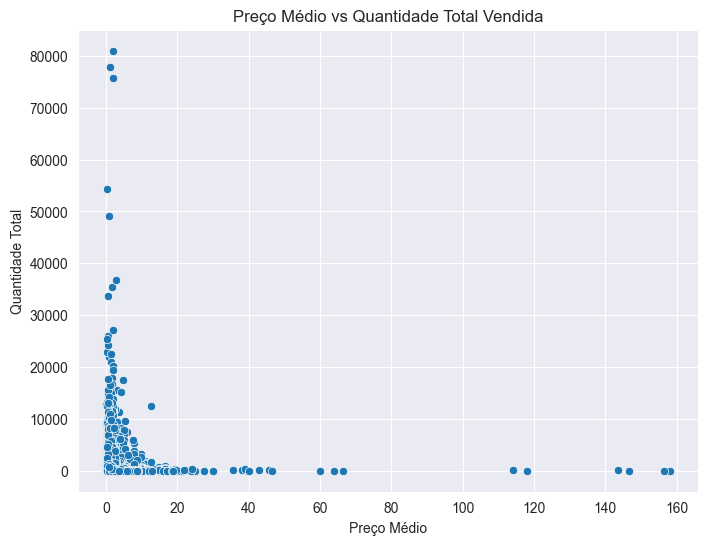

In [8]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=product_df,
    x="avg_price",
    y="total_quantity"
)
plt.title("Preço Médio vs Quantidade Total Vendida")
plt.xlabel("Preço Médio")
plt.ylabel("Quantidade Total")
plt.show()

#### Comportamento esperado:
- Quanto maior o preço, menor a demanda ***(região inferior a direita do gráfico)***.

- Quanto menor o preço, maior a demanda ***(região superior a esqueda do gráfico)***.

# Elasticidade-Preço da Demanda:

A elasticidade ($E_p$) mostra o quanto que o preço de um produto afeta em sua demanda (ou quantidade de produtos vendidos).

$ E_p = \dfrac{\% \text{Variação na quantidade demandada}}{\% \text{Variação no preço}}$

### Modelo log-log:

$\log{Q} = \alpha + \beta \log{P}$

O valor de $\beta$ é exatamente a elasticidade.

Características do $\beta$:

- $\beta < 0$ ***(Elasticidade Negativa)*** -> Demanda diminui com o aumento do preço.
- $| \beta |$ ***(Valor absoluto da Elasticidade)*** -> Intensidade de resposta do consumidor a alteração do preço.
    - $| \beta | < 1$ -> Demanda inelástica <mark>***(Aumento de preço gera pequena redução na demanda)***</mark>
    - $| \beta | > 1$ -> Demanda elástica <mark>***(Um pequeno aumento no preço gera uma grande queda na demanda)***</mark>

In [14]:
product_df["log_price"] = np.log(product_df["avg_price"])
product_df["log_quantity"] = np.log(product_df["total_quantity"])

x = product_df[["log_price"]]
y = product_df["log_quantity"]

model = LinearRegression()
model.fit(x, y)

elasticity = model.coef_[0]
print(elasticity)

-0.7035155258834016


##### O valor absoluto de $0.7$ para elasticidade indica demanda elástica, ou seja, um aumento no preço gera pouca queda na quantidade de produtos vendidos.

<mark>*Obs.: Note que essa valor foi calculado para ***todos os produtos***.*</mark>

# Elasticidade por produto:

Para finalizar a análise, irei determinar a elasticidade de cada produto.

In [71]:
elasticities = []

for product, data in df.groupby("stock_code_cleaned"):

    # Quantidade total vendida do produto
    total_quantity = data["quantity_cleaned"].sum()

    # Filtrar produtos com no mínimo 3 preços distintos, para garantir menor ruído no 'Linear Regression'
    if data["unit_price_cleaned"].nunique() < 3:
        continue

    # Agrupa por total vendido para determinado preço
    data = data.groupby("unit_price_cleaned")["quantity_cleaned"].sum().reset_index()

    data["log_price"] = np.log(data["unit_price_cleaned"])
    data["log_quantity"] = np.log(data["quantity_cleaned"])

    X = data[["log_price"]]
    y = data["log_quantity"]

    model = LinearRegression().fit(X, y)

    elasticities.append({
        "stock_code": product,
        "total_quantity": total_quantity,
        "elasticity": model.coef_[0]
    })

elasticity_df = pd.DataFrame(elasticities)
elasticity_df.head()

,stock_code,total_quantity,elasticity
0,10135,1938,0.155150
1,11001,1252,-3.687880
2,15036,21876,4.464883
3,15044,1637,-7.051606
4,15056,7374,-0.763907


# Classificação da elasticidade:

In [72]:
def classify_elasticity(e):
    if e < -1:
        return "Elástico"
    elif -1 <= e < 0:
        return "Inelástico"
    elif e == 0:
        return "Perfeitamente Inelástico"
    else:
        return "Elasticidade Positiva (?)"

elasticity_df["category"] = elasticity_df["elasticity"].apply(classify_elasticity)
elasticity_df.head()

,stock_code,total_quantity,elasticity,category
0,10135,1938,0.155150,Elasticidade Positiva (?)
1,11001,1252,-3.687880,Elástico
2,15036,21876,4.464883,Elasticidade Positiva (?)
3,15044,1637,-7.051606,Elástico
4,15056,7374,-0.763907,Inelástico


# Visualizando as Elasticidades por Produto:

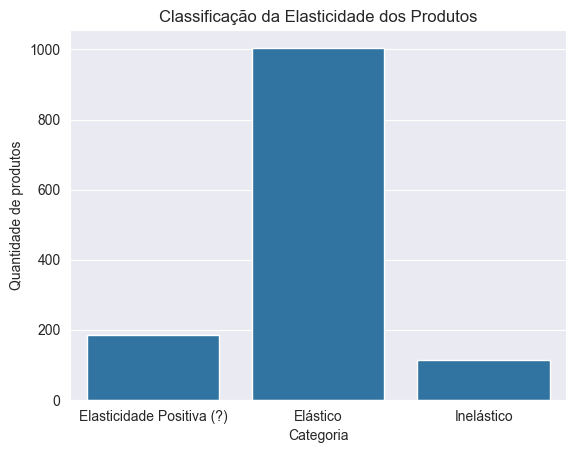

In [73]:
sns.countplot(
    data=elasticity_df,
    x="category"
)

plt.xlabel("Categoria")
plt.ylabel("Quantidade de produtos")
plt.title("Classificação da Elasticidade dos Produtos")
plt.show()

# Elasticidade Positiva?

A existência de uma elasticidade positiva é contraintuitivo, seria como dizer <mark> "Aumentar o preço faz com que mais pessoas comprem" </mark>.

Portanto, esse fenômeno ocorre na análise devido a premissa inicial de que <mark> "Apenas o preço altera a demanda" </mark>, o que também é contraituitivo, pois existem diversos outros fatores que afetam a demanda do produto. Esses fatores serão analisados posteriormente.

Dito isso, é preciso usar a elasticidade com cautela em tomadas de decisões.

# Visualizando a relação entre Elasticidade e Preço Médio:

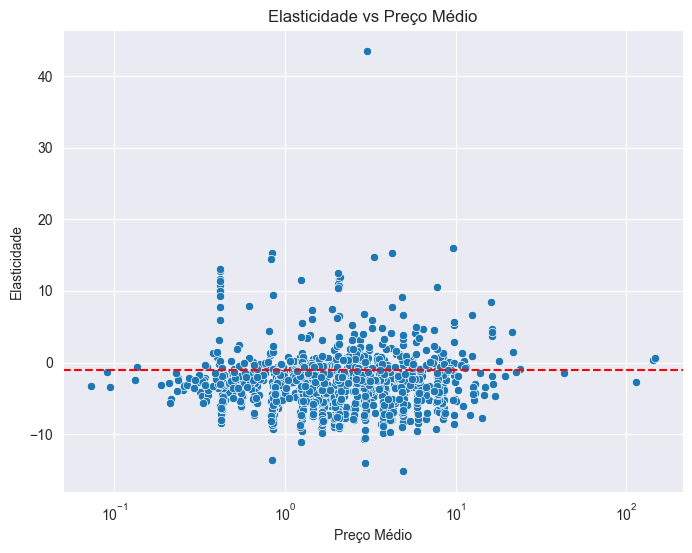

In [62]:
merged = elasticity_df.merge(
    product_df,
    left_on="stock_code",
    right_on="stock_code_cleaned",
    how="inner"
)

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=merged,
    x="avg_price",
    y="elasticity"
)
plt.axhline(-1, color="red", linestyle="--")
plt.xscale("log")
plt.xlabel("Preço Médio")
plt.ylabel("Elasticidade")
plt.title("Elasticidade vs Preço Médio")
plt.show()

O gráfico mostra que:
- <mark>produtos baratos -> maior elasticidade.</mark>

# Visualizando a relação entre Elasticidade e Receita:


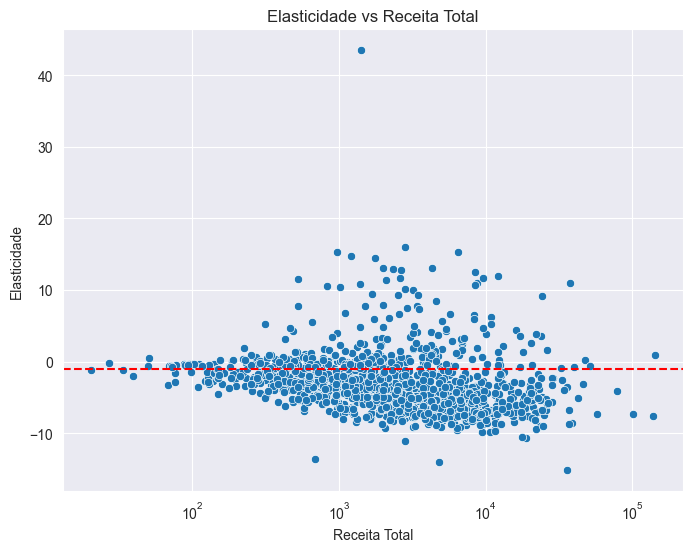

In [63]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=merged,
    x="total_revenue",
    y="elasticity"
)
plt.axhline(-1, color="red", linestyle="--")
plt.xscale("log")
plt.xlabel("Receita Total")
plt.ylabel("Elasticidade")
plt.title("Elasticidade vs Receita Total")
plt.show()

O gráfico mostra que existe uma relação inversa entre receita e elasticidade:
- <mark>Produtos com mais receita -> Maior Elasticidade;</mark>
- <mark>Produtos com menos receita -> Menor Elasticidade.</mark>

# Coefiente de Pearson (r):

Irei determinar o quão correlacionado está o preço com a quantidade de produtos vendidos.

Sobre o coeficiente de Pearson:

- ***r = -1*** -> Correlação negativa (quando uma aumenta, outra sempre diminui);
- ***r = +1*** -> Correlação positiva (quando uma aumenta, outra sempre aumenta);
- ***r = 0*** -> Não existe relação linear entre as duas.

$r \in [-1,1]$

In [79]:
pearson_df = (
    df.groupby("unit_price_cleaned")["quantity_cleaned"]
      .sum()
      .reset_index()
)

pearson_corr = pearson_df["unit_price_cleaned"].corr(
    pearson_df["quantity_cleaned"],
    method="pearson"
)

print(pearson_corr)

-0.06804568131074692


### A correlação ($r \approx -0.07$) é próxima de 0, o que indica pouca correlação linear entre preço e demanda, porém negativa, ou seja, ao aumentar o preço, diminui a demanda.